In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [50]:
df = pd.read_csv('upPackets.csv', sep= ";")

In [51]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,datr,codr,rssi,lsnr,size,data
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-100,2.8,9,CieFBjcaAv4B
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-99,4.0,9,CieFBjcaAv4B
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,2.3,8,C8bTDAVZBQA=
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,0.5,9,C8bTDAVZAv4B
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-111,1.5,8,CyCSDMkzAQA=


In [52]:
df.shape

(5895982, 16)

In [53]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [54]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [55]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,5.0,,NaN,None
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,65026.0,01,NaN,None
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,11.0,0.0,2.0,3.0,c90c9220,51.0,1.0,,NaN,None


In [56]:
df.columns

Index(['id', 'gwui', 'time', 'tmms', 'tmst', 'freq', 'chan', 'rfch', 'stat',
       'modu', 'datr', 'codr', 'rssi', 'lsnr', 'size', 'MHDR', 'MType', 'RFU',
       'Major', 'DevAddr', 'FCtrl', 'FCnt', 'FOpts', 'FPort', 'FRMPayload'],
      dtype='object')

In [57]:
df.shape

(5895982, 25)

In [58]:
df.duplicated().sum() #No duplicate rows

0

In [59]:
df["gwui"].nunique() # Only one gateway

2

In [60]:
len(df["DevAddr"].unique()) #5364 end devices

166984

In [61]:
# Show count of NaNs per column
nan_counts = df.isna().sum()

# Display only columns with at least one NaN
print(nan_counts[nan_counts > 0])

MHDR               69
MType              69
RFU                69
Major              69
DevAddr            69
FCtrl              69
FCnt               69
FOpts         2304644
FPort         3081006
FRMPayload    3093266
dtype: int64


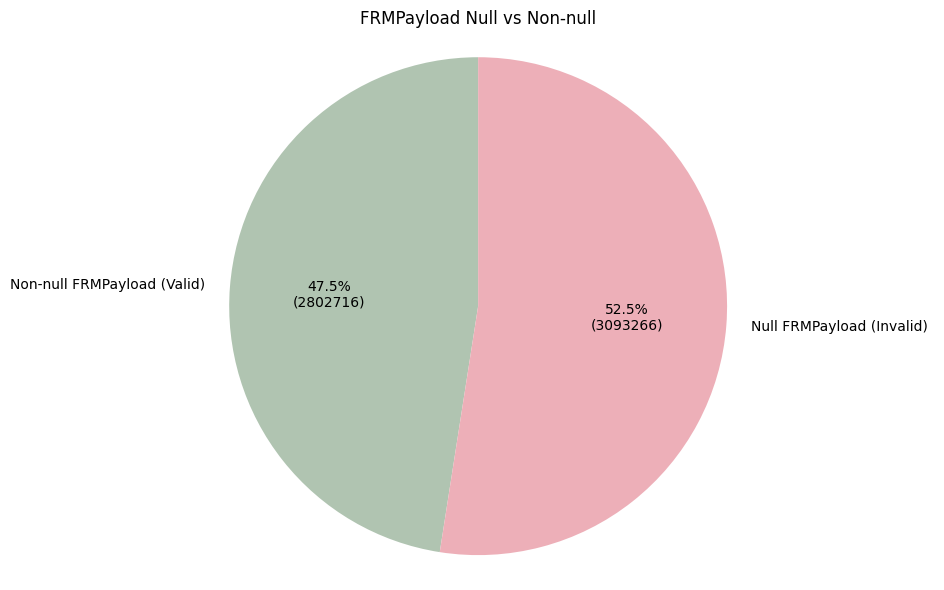

In [62]:
# Count null and non-null values
null_count = df['FRMPayload'].isnull().sum()
non_null_count = df['FRMPayload'].notnull().sum()

labels = ['Non-null FRMPayload (Valid)', 'Null FRMPayload (Invalid)']
values = [non_null_count, null_count]
colors = [ '#b0c4b1', '#edafb8']

# Custom function to show both count and percentage
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Plot
plt.figure(figsize=(10, 6))
plt.pie(
    values,
    labels=labels,
    colors=colors,
    autopct=lambda pct: autopct_format(pct, values),
    startangle=90
)
plt.title("FRMPayload Null vs Non-null")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [63]:
df_null_frmpayload = df[df['FRMPayload'].isnull()]
df_valid_packets = df[df['FRMPayload'].notnull()]

#FPort Analysis

In [64]:
df_valid_packets["FPort"].unique()

array([ 64.,  10.,   0.,   1.,   2.,   3.,  17.,  31., 111.,   5.,  13.,
       167.,  77., 224., 120.,  46.,  78., 123., 237., 255.,   9.,  15.,
        85.,  34.,  97., 216.,  44.,  23., 110., 171., 144., 155., 180.,
       248., 100.,  25., 141., 235., 254., 159., 187., 106.,  68.,  18.,
       189.,  32.,  35.,  12., 211.,  62.,   4.,  22., 172., 164.,  36.,
        61., 124.,  93.,  59.,  90., 219.,  55., 150., 188., 161., 143.,
        38., 197.,  43., 206.,  27., 223.,  19., 182., 101., 184., 168.,
        83., 162.,  74.,  21., 163.,   8., 166.,  92.,  63.,  47., 126.,
       210., 113., 245.,  87., 201.,  11., 152., 112., 234., 247., 146.,
        20., 154., 135., 131., 102., 251., 132.,  99.,  26.,  71., 198.,
       226.,  89.,   6.,  79.,  48., 240.,  65., 253., 169.,  67., 128.,
       246., 139.,  69., 222., 174.,  29.,  49., 252., 200., 138., 205.,
        88.,  24.,  41., 195., 242., 203.,  70., 190., 125., 175., 103.,
       177., 145.,  51.,  95.,  53., 127., 109., 10

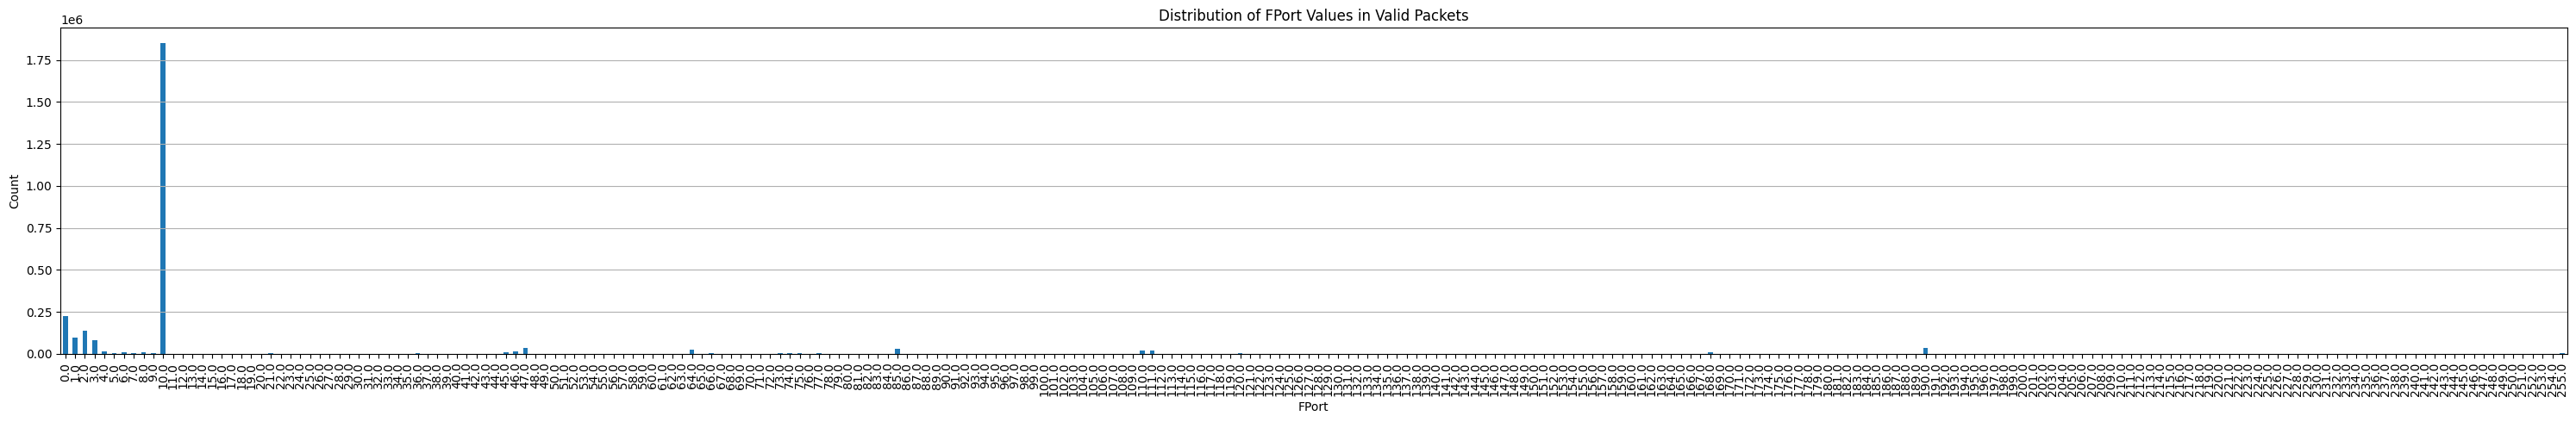

In [65]:
# Create a histogram (bar chart) of the FPort column
fport_counts = df_valid_packets["FPort"].value_counts().sort_index()

plt.figure(figsize=(30, 5))
fport_counts.plot(kind='bar')
plt.xlabel("FPort")
plt.ylabel("Count")
plt.title("Distribution of FPort Values in Valid Packets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [66]:
# Count FPort occurrences
fport_counts = df_valid_packets["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports = fport_counts[fport_counts.index >= 244]
special_use_sum = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned = fport_counts.drop(special_use_fports.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports = fport_counts_cleaned.drop(top_6.index, errors='ignore')
others_sum = remaining_fports.sum()

# Combine all into final Series
final_series = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum}),
    pd.Series({'Others': others_sum})
])

# Convert to lists
labels = final_series.index.tolist()
values = final_series.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels, values=values, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Valid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

FPort_category
Application    2559761
Control         223671
Reserved         19284
Name: count, dtype: int64


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/1627989326.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



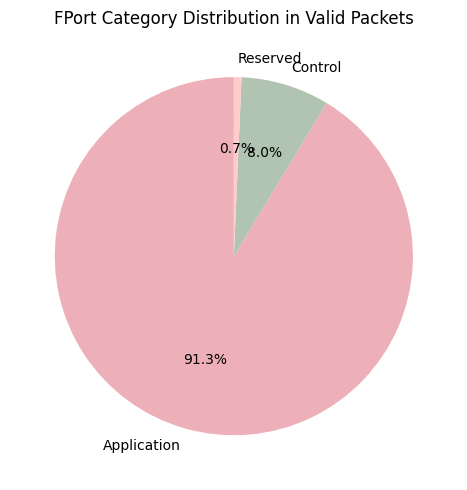

In [67]:
# Filter only packets with valid payload
valid_packets = df[df['FRMPayload'].notnull()]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
valid_packets['FPort_category'] = valid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = valid_packets['FPort_category'].value_counts()

print(category_counts)

# Optional: Plot the distribution as a pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#edafb8', '#b0c4b1', '#ffcccb'])
plt.title('FPort Category Distribution in Valid Packets')
plt.ylabel('')  # Remove the default label
plt.tight_layout()
plt.show()


In [68]:
# Count FPort occurrences
fport_counts_invalid = df_null_frmpayload["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports_invalid = fport_counts_invalid[fport_counts.index >= 244]
special_use_sum_invalid = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned_invalid = fport_counts_invalid.drop(special_use_fports_invalid.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned_invalid.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports_invalid = fport_counts_cleaned_invalid.drop(top_6.index, errors='ignore')
others_sum_invalid = remaining_fports_invalid.sum()

# Combine all into final Series
final_series_invalid = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum_invalid}),
    pd.Series({'Others': others_sum_invalid})
])

# Convert to lists
labels_invalid = final_series_invalid.index.tolist()
values_invalid = final_series_invalid.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels_invalid, values=values_invalid, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Invalid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

FPort_category
Unknown        3081006
Control           7136
Application       4804
Reserved           320
Name: count, dtype: int64


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/678024755.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



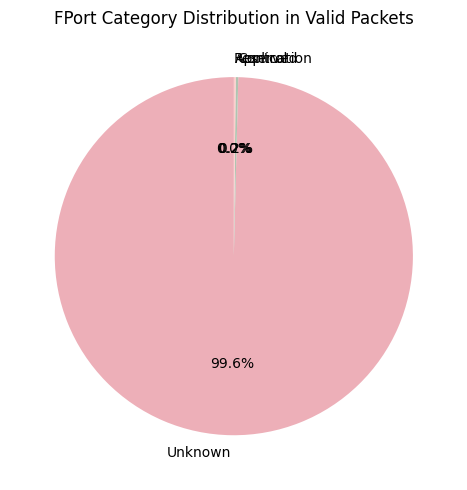

In [69]:
# Filter only packets with valid payload
invalid_packets = df[df['FRMPayload'].notnull()==False]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
invalid_packets['FPort_category'] = invalid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = invalid_packets['FPort_category'].value_counts()

print(category_counts)

# Optional: Plot the distribution as a pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#edafb8', '#b0c4b1', '#ffcccb'])
plt.title('FPort Category Distribution in Valid Packets')
plt.ylabel('')  # Remove the default label
plt.tight_layout()
plt.show()


# Device Count by Number of Packets Sent

Maximum number of packets sent by a device: 99371


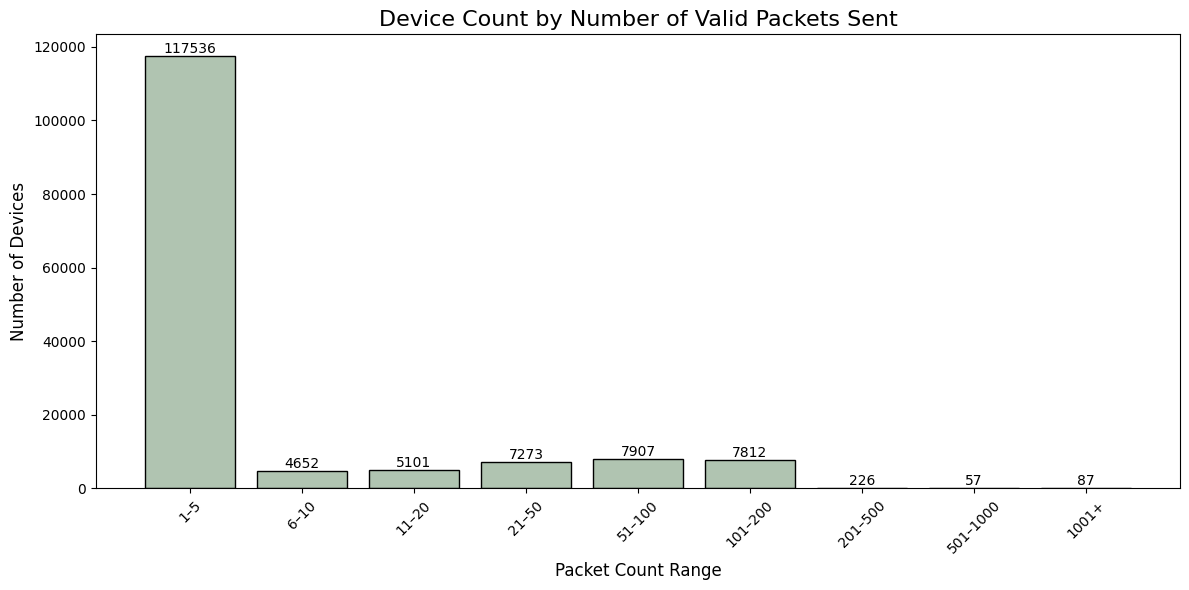

In [70]:
# Count how many packets per DevAddr
devaddr_counts = df_valid_packets['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts.max())
# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned = pd.cut(devaddr_counts, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(binned_counts.index.astype(str), binned_counts.values, edgecolor='black', color='#b0c4b1')
plt.title('Device Count by Number of Valid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

Maximum number of packets sent by a device: 169259


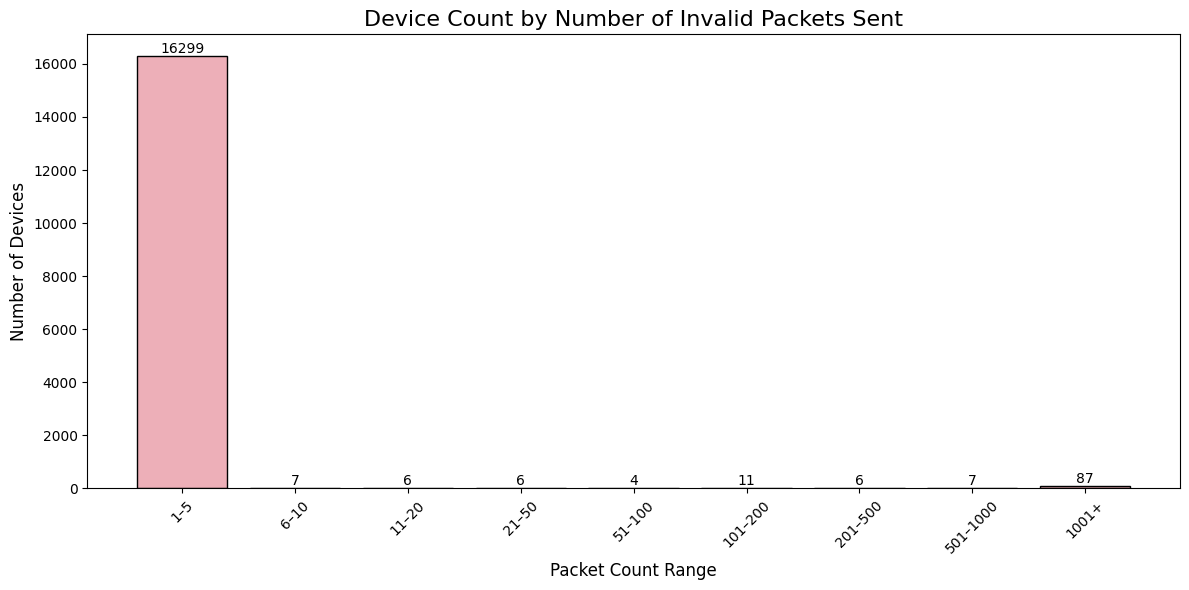

In [71]:
# Count how many packets per DevAddr
devaddr_counts_invalid = df_null_frmpayload['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts_invalid.max())

# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned_invalid = pd.cut(devaddr_counts_invalid, bins=bins, labels=labels, right=False)
binned_counts_invalid = binned_invalid.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars_invalid= plt.bar(binned_counts_invalid.index.astype(str), binned_counts_invalid.values, edgecolor='black', color='#edafb8')
plt.title('Device Count by Number of Invalid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars_invalid:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

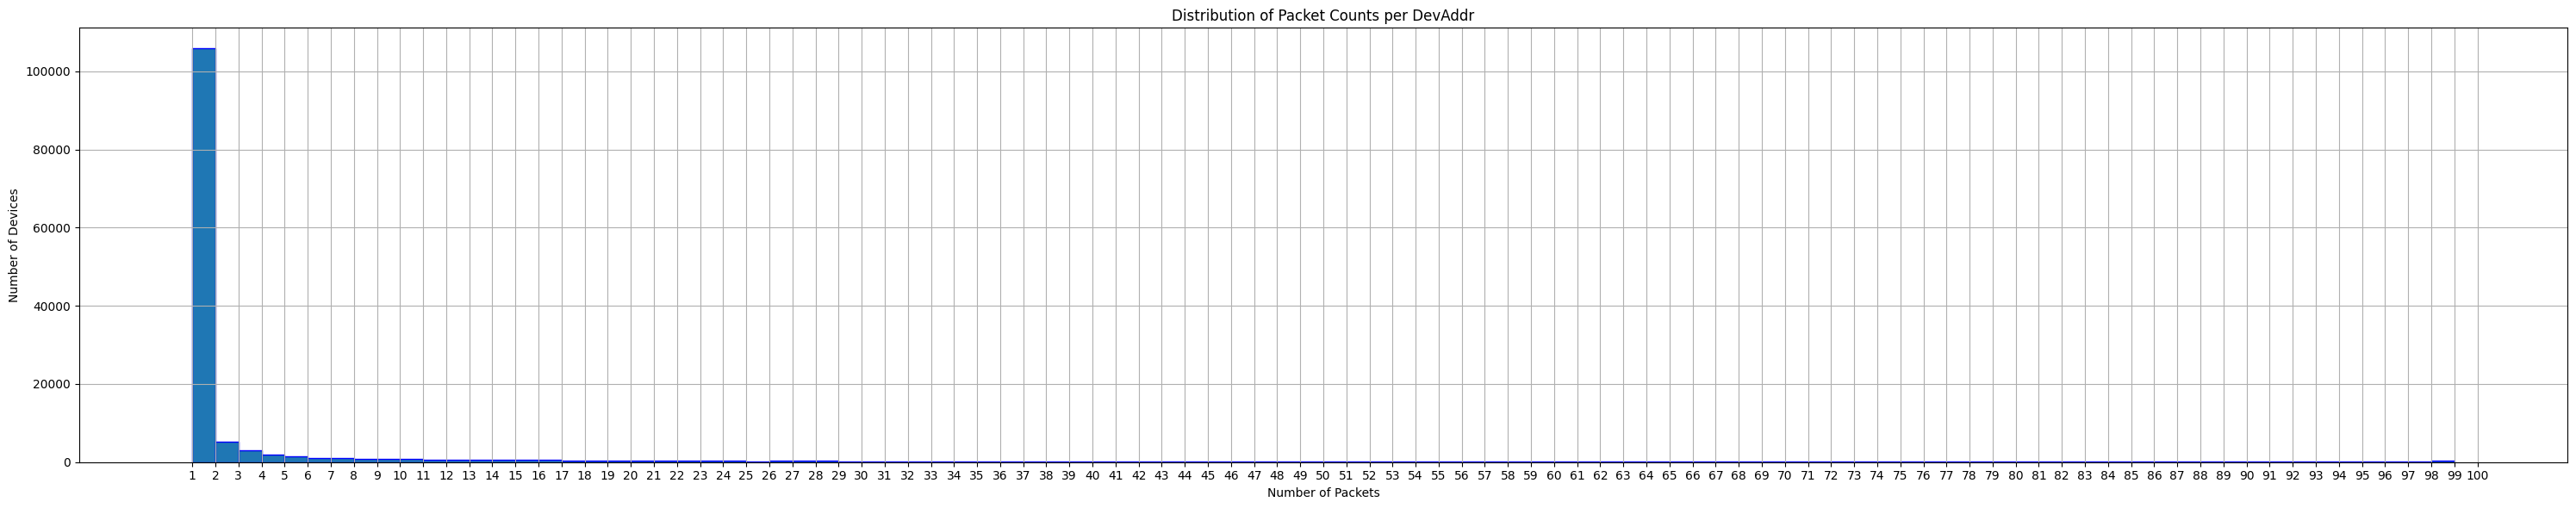

In [72]:
# A close up histogram
plt.figure(figsize=(30, 6))
plt.hist(devaddr_counts, bins=range(1, 100), edgecolor='blue')
plt.title('Distribution of Packet Counts per DevAddr')
plt.xlabel('Number of Packets')
plt.ylabel('Number of Devices')
plt.grid(True)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

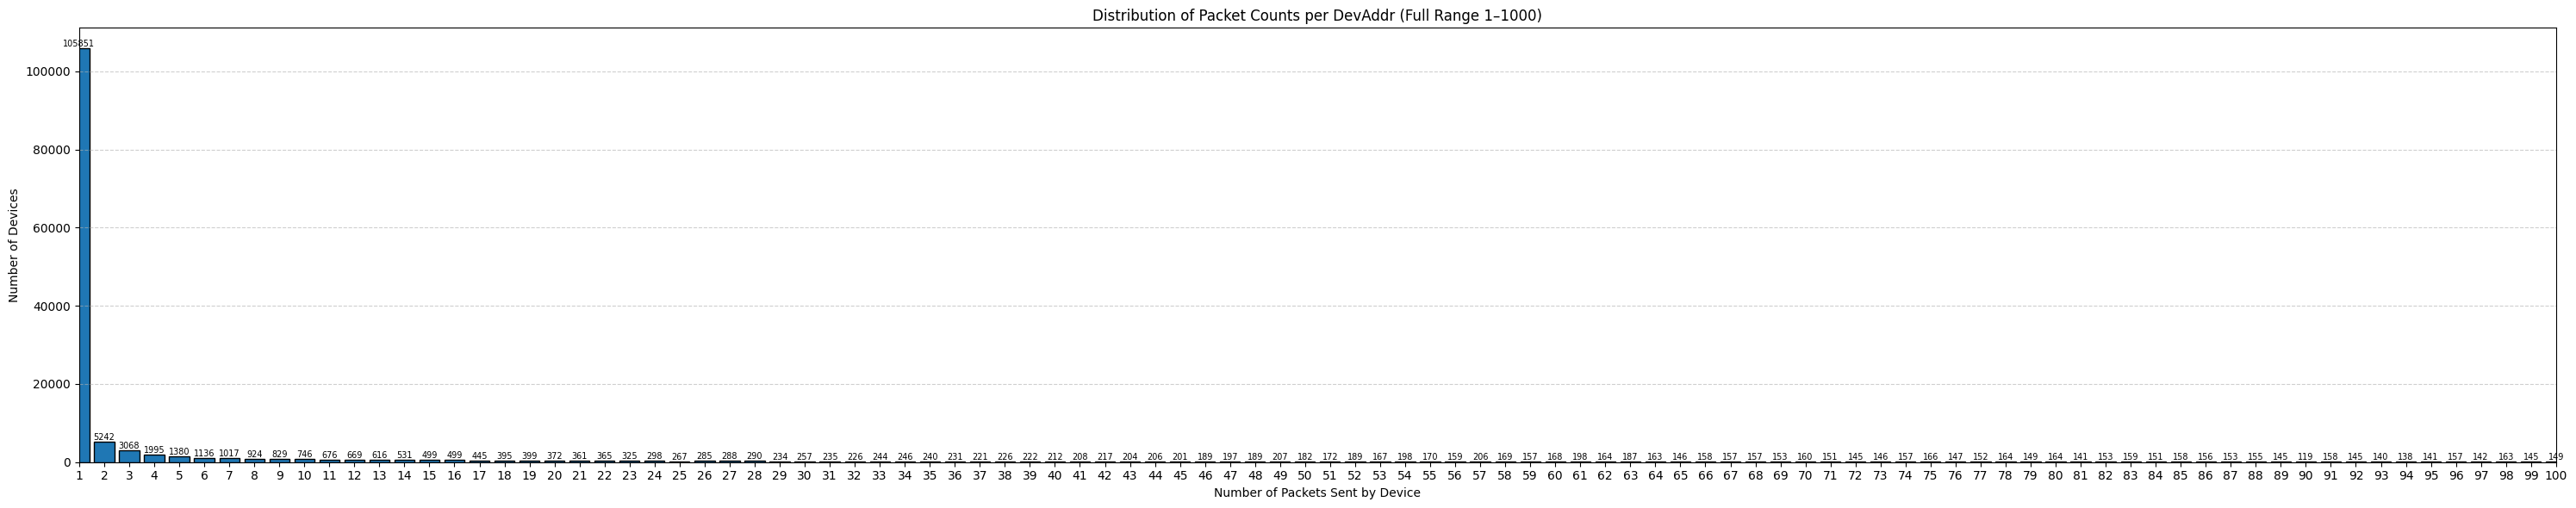

In [73]:
# Count how many devices sent X packets
packet_distribution = devaddr_counts.value_counts().sort_index()

# Ensure full x-axis from 1 to 1000
full_range = pd.Series(index=range(1, 101), dtype=int)
packet_distribution = packet_distribution.reindex(full_range.index, fill_value=0)

# Plot bar chart
plt.figure(figsize=(30, 6))
bars = plt.bar(packet_distribution.index, packet_distribution.values, edgecolor='black')

# Optionally add labels (skip if too crowded)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
  ha='center', va='bottom', fontsize=7)

plt.title('Distribution of Packet Counts per DevAddr (Full Range 1–1000)')
plt.xlabel('Number of Packets Sent by Device')
plt.ylabel('Number of Devices')
plt.xlim(1, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

# RSSI Histogram


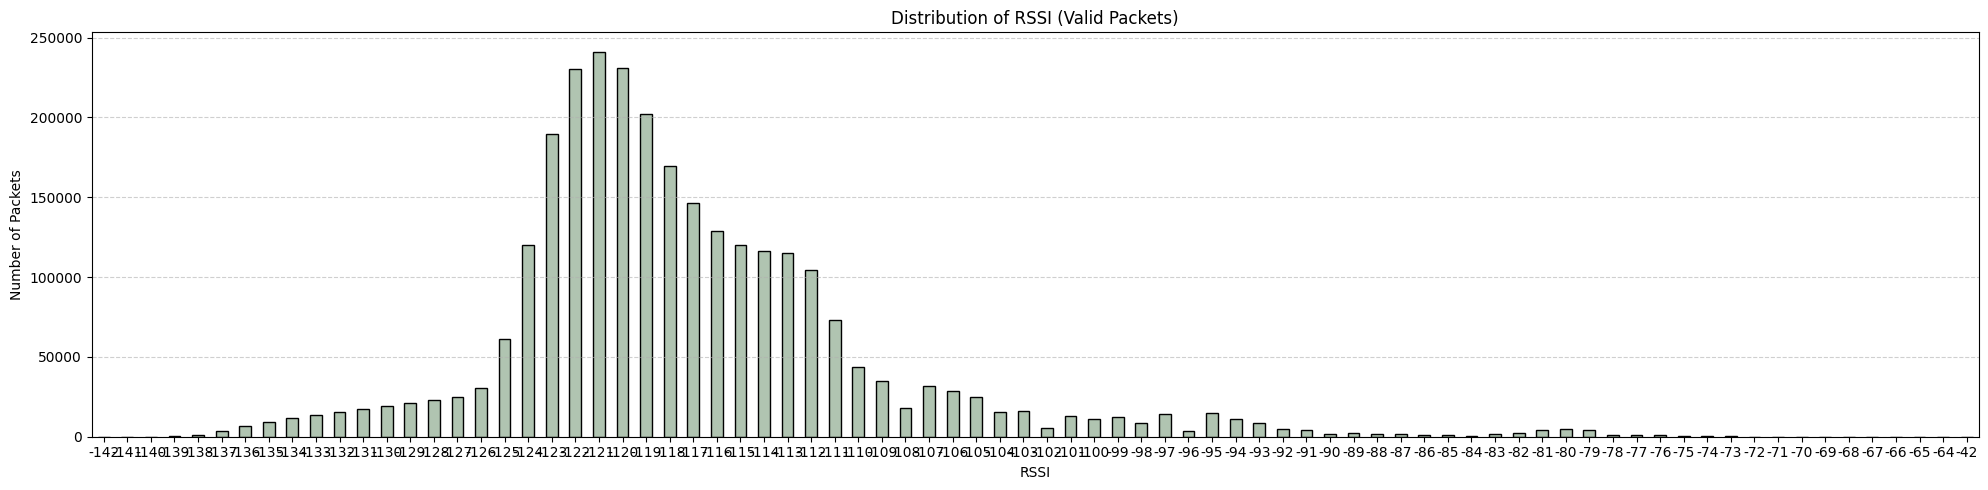

In [74]:
# Count and sort rssi values
rssi_counts = df_valid_packets['rssi'].value_counts().sort_index()

plt.figure(figsize=(20, 5))
rssi_counts.plot(kind='bar', color='#b0c4b1',  edgecolor='black')
plt.title('Distribution of RSSI (Valid Packets)')
plt.xlabel('RSSI')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

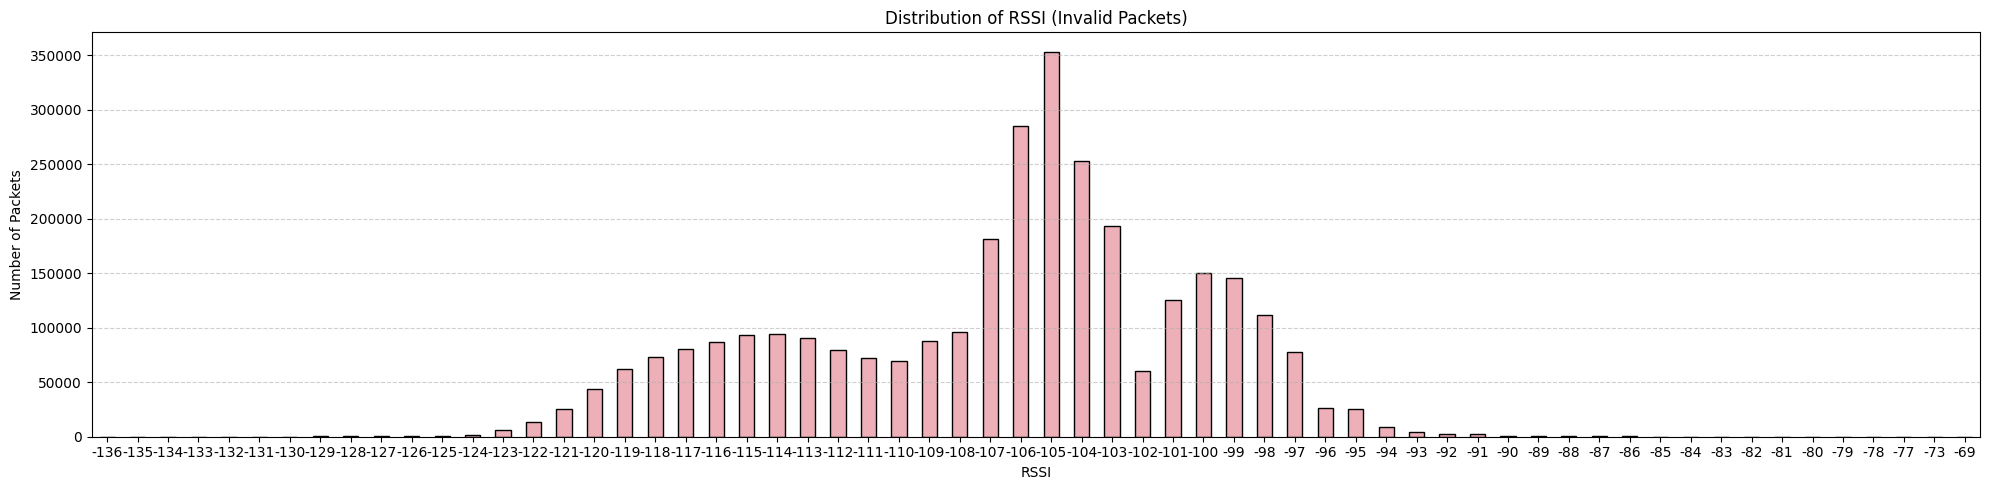

In [75]:
# Count and sort rssi values
rssi_counts_invalid = df_null_frmpayload['rssi'].value_counts().sort_index()

plt.figure(figsize=(20, 5))
rssi_counts_invalid.plot(kind='bar', color='#edafb8', edgecolor='black')
plt.title('Distribution of RSSI (Invalid Packets)')
plt.xlabel('RSSI')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#SF Histogram

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/2421202418.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



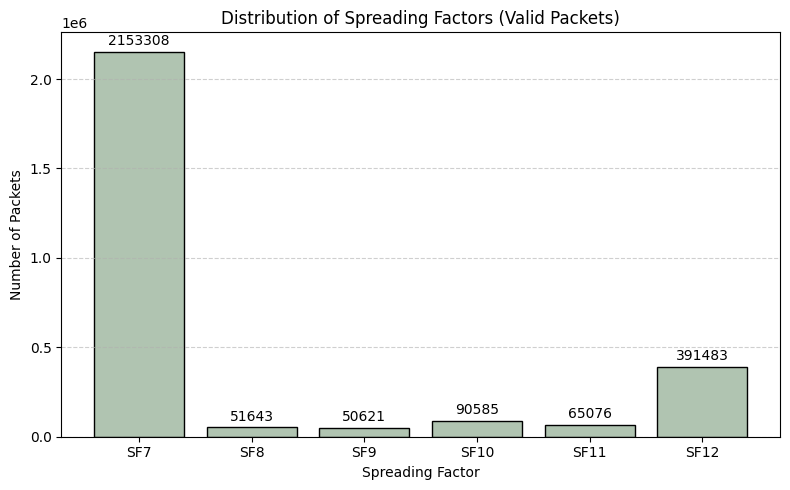

In [76]:
# Extract numeric SF
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Spreading Factors (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_valid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/3317343131.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



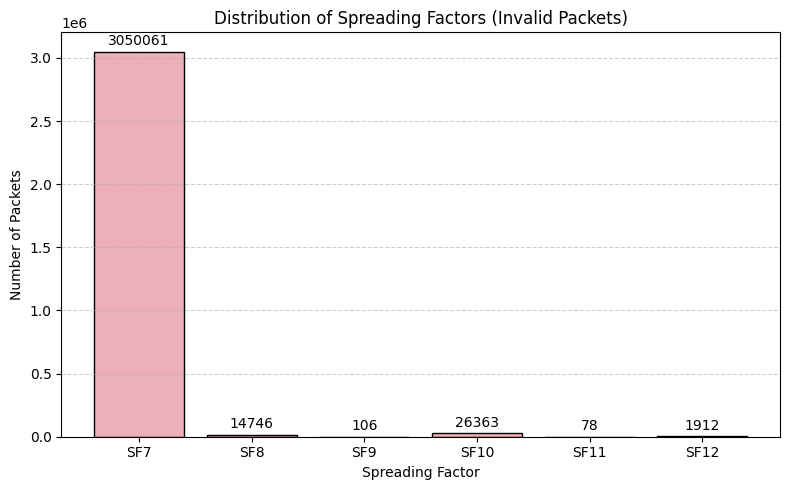

In [77]:
# Extract numeric SF
df_null_frmpayload['sf_num'] = df_null_frmpayload['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_invalid = df_null_frmpayload['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_invalid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_invalid.values, edgecolor='black', color="#edafb8")
plt.title('Distribution of Spreading Factors (Invalid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_invalid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Per Device Loss Ratio
Loss Ratio= Total Expected Packets / Total Lost Packets

In [78]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,5.0,,NaN,None
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,65026.0,01,NaN,None
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,11.0,0.0,2.0,3.0,c90c9220,51.0,1.0,,NaN,None


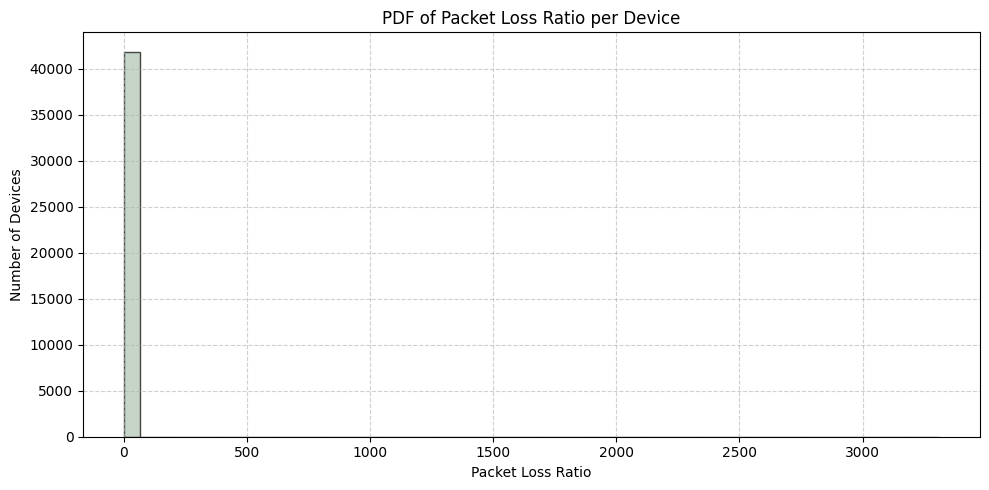

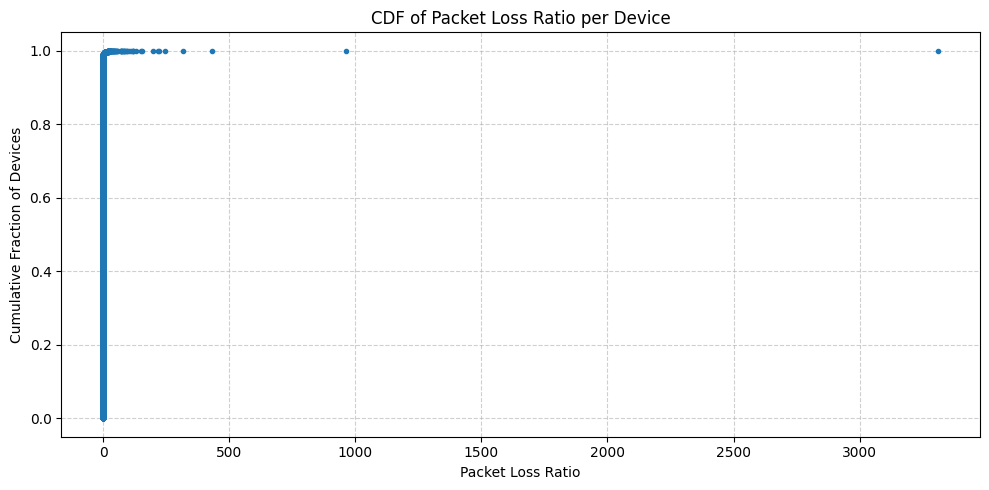

In [79]:
loss_ratios = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:  # avoid divide by zero
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)

loss_ratios = np.array(loss_ratios)

# Plot PDF
plt.figure(figsize=(10, 5))
plt.hist(loss_ratios, bins=50, edgecolor='black', alpha=0.7, color='#b0c4b1')
plt.title('PDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot CDF
plt.figure(figsize=(10, 5))
sorted_ratios = np.sort(loss_ratios)
cdf = np.arange(len(sorted_ratios)) / len(sorted_ratios)
plt.plot(sorted_ratios, cdf, marker='.', linestyle='none')
plt.title('CDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Cumulative Fraction of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Network Wide Loss Rate
NC = uplink packets correctly received
NL = lost packets
lost= NL / (NC + NL)

In [80]:
total_lost = 0
total_received = 0

for dev, group in df.dropna(subset=['DevAddr', 'FCnt']).groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values

    if len(fcnts) < 2:
        continue  # Not enough data

    fcnt_diffs = np.diff(fcnts)
    lost = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    received = len(fcnts)

    total_lost += lost
    total_received += received

# Network-wide loss rate
total_expected = total_lost + total_received
loss_ratio = total_lost / total_expected
total_lost

print(f"Network-wide packet loss rate: {loss_ratio:.6f}")

Network-wide packet loss rate: 0.999884


# Time analysis

In [81]:
from datetime import datetime

In [86]:
df_valid_packets['tmst_str'] = df_valid_packets['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_null_frmpayload['tmst_str'] = df_null_frmpayload['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/3254569488.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/3254569488.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
print(df_valid_packets.tmst_str.max())
print(df_valid_packets.tmst_str.min())

2025-05-15 15:03:25
2024-10-17 18:06:47


In [88]:
print(df_null_frmpayload.tmst_str.max())
print(df_null_frmpayload.tmst_str.min())

2025-05-15 15:03:24
2024-10-17 18:06:47


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/863306747.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/863306747.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



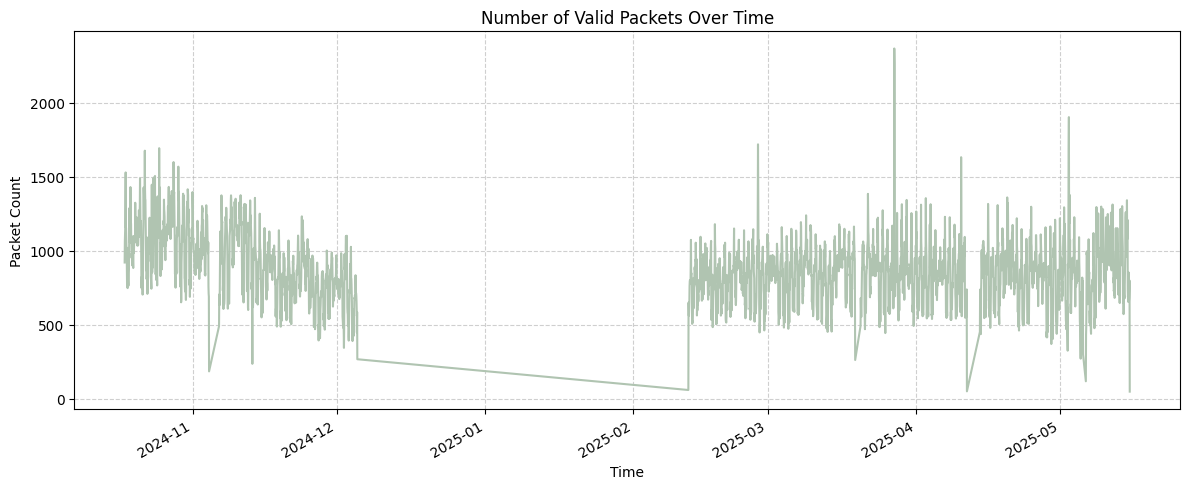

In [84]:
# Convert tmst_str back to datetime type
df_valid_packets['tmst_datetime'] = pd.to_datetime(df_valid_packets['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_valid_packets['time_bin'] = df_valid_packets['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts = df_valid_packets.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts.plot(kind='line', color="#b0c4b1")
plt.title('Number of Valid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/2410637500.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_976/2410637500.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



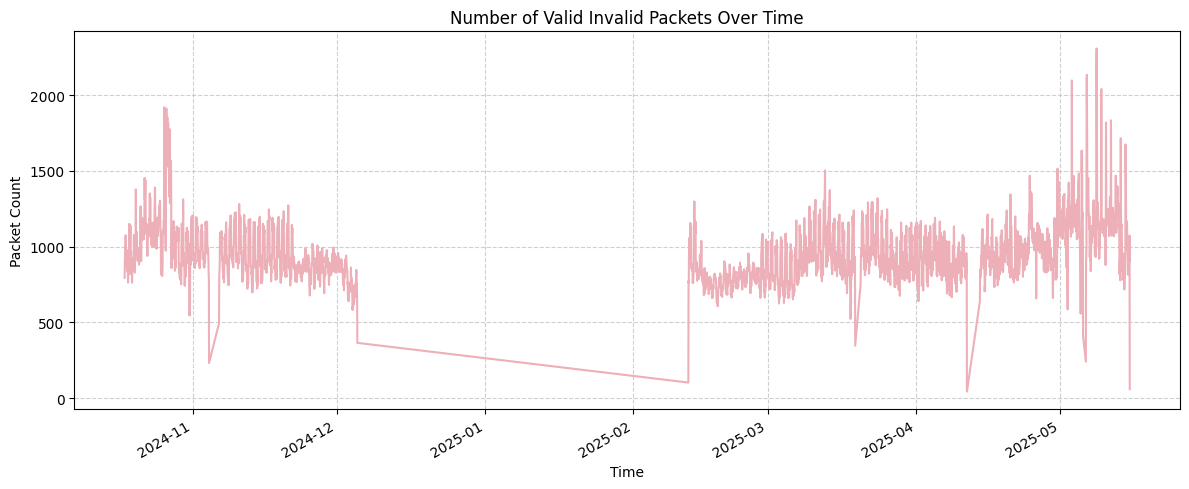

In [89]:
# Convert tmst_str back to datetime type
df_null_frmpayload['tmst_datetime'] = pd.to_datetime(df_null_frmpayload['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_null_frmpayload['time_bin'] = df_null_frmpayload['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts_invalid = df_null_frmpayload.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts_invalid.plot(kind='line', color="#edafb8")
plt.title('Number of Valid Invalid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()